In [1]:
# Operaciones de archivos
import os
from os import listdir

import pickle
import zipfile
import shutil
from glob import glob

# Operaciones de datos
import pandas as pd
import numpy as np

# Operaciones de imágenes
from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import nibabel as nib

# Visualización
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Utilidades
import random
from time import time
import uuid
import re
import gc
from pprint import pprint
import itertools

## Comprensión Inicial de Imágenes

### Imágenes DICOM

Una imagen DICOM (Digital Imaging and Communications in Medicine) es un formato estándar utilizado en la industria de la salud para almacenar y transmitir imágenes médicas junto con la información asociada a ellas. Los archivos con la extensión .dcm contienen no solo la imagen digital (por ejemplo, de una radiografía, tomografía, resonancia magnética, etc.), sino también metadatos detallados como el nombre del paciente, la fecha del examen, el tipo de imagen, y otros datos importantes para el diagnóstico médico. DICOM permite la interoperabilidad entre diferentes sistemas y dispositivos médicos, garantizando que las imágenes puedan ser compartidas, visualizadas y procesadas por diferentes máquinas y softwares en hospitales y clínicas. Este formato ha sido fundamental para el desarrollo de la telemedicina y el análisis médico automatizado.

Referencias:
- DICOM. (s. f.). About DICOM- Overview. https://www.dicomstandard.org/about 
- Intelerad. (2024). What is DICOM Image Format & Why is It Important in Radiology? https://www.intelerad.com/en/2023/02/23/handling-dicom-medical-imaging-data/

### Metadata DICOM

In [2]:
# Seleccionar una de las imagenes de alguna carpeta
example_path = "data/train_images/1.2.826.0.1.3680043.14/1.dcm"

dcm_example = pydicom.dcmread(example_path)
display(dcm_example)

Dataset.file_meta -------------------------------
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.14.1.1
(0002,0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.14.1.1
(0008,0023) Content Date                        DA: '20220727'
(0008,0033) Content Time                        TM: '180841.008575'
(0010,0010) Patient's Name                      PN: '14'
(0010,0020) Patient ID                          LO: '14'
(0018,0050) Slice Thickness                     DS: '0.6'
(0020,000D) Study Instance 

Los datos de la tomografía se almacenan en un array bajo el nombre de **Pixel Data**. Todo lo demas son metadatos relacionados. 

Algunos de los mas relevantes a tomar en cuenta son:

- `Rows`: La altura de la imagen o tomografía.
- `Columns`: El ancho de la imagen o tomografía.
- `SOPInstanceUID`: Identificador único que contiene el `StudyInstanceUID` más el número de corte.
- `ContentDate`: La fecha en que comenzó la creación de los datos de píxeles de la imagen.
- `SliceThickness`: Indica el grosor de la sección de imagen.
- `InstanceNumber`: Número de corte.
- `ImagePositionPatient`: Las coordenadas x, y, y z de la esquina superior izquierda (centro del primer voxel transmitido) de la imagen, en mm.
- `ImageOrientationPatient`: Los cosenos directores de la primera fila y la primera columna con respecto al paciente.
- `Pixel Data`: Los datos de la imagen se almacenan en una matriz.
- `Pixel Spacing`: Espaciado entre los píxeles.
- `Window Center`: Información sobre el brillo de la imagen.
- `Window Width`: Información sobre el contraste de la imagen.
- `Rescale Intercept`: Determina el rango de los valores de los píxeles (intercepto).
- `Rescale Slope`: Determina el rango de los valores de los píxeles (pendiente).

La combinación de los atributos `Rows` y `Columns` proporciona el tamaño de la imagen, mientras que `Pixel Spacing` y `SliceThickness` indican el tamaño de los píxeles y el grosor de los cortes. `Window Center` y `Window Width` proporcionan la información sobre el brillo y el contraste de la imagen. `ImagePositionPatient` da las coordenadas x, y, z de la esquina superior izquierda de cada imagen en mm. `InstanceNumber` corresponde al número de corte.

Si desea saber mas sobre el resto de atributos de la tomografía puede visitar el siguiente enlace:
- https://dicom.innolitics.com/ciods/ct-image

### Muestreo de Tomografías

#### Funciones Auxiliares

In [3]:
def atoi(text):
    """
    Convierte texto a entero si es posible, 
    de lo contrario devuelve el texto original.

    Args:
        text (str): Texto a convertir

    Returns:
        int: Texto convertido a entero si es posible
    """
    return int(text) if text.isdigit() else text

In [4]:
def natural_keys(text):
    """
    Clave de ordenación para ordenar alfanuméricamente.

    Args:
        text (str): Cadena de texto.

    Returns:
        list: Lista de enteros y texto
    """
    return [atoi(c) for c in re.split(r'(\d+)', text)]

In [5]:
def get_subfolder_names(folder_path):
    """
    Obtiene los nombres de todas las subcarpetas en una carpeta dada.

    Args:
        folder_path (str): Ruta de la carpeta principal.

    Returns:
        list: Lista con los nombres de las subcarpetas.
    """
    return [name for name in listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

In [6]:
studies_ids = get_subfolder_names("data/train_images")

#### Visualización

In [7]:
def show_dcm_slices(scan_id, base_path="data", rows=2, cols=4):
    """
    Muestra una selección de imágenes de un estudio dado en formato DICOM.

    Args:
        base_path (str): Ruta base de los datos.
        scan_id (str): ID del estudio a visualizar.

    Returns:
        None
    """
    

    dcm_paths = glob(f"{base_path}/train_images/{scan_id}/*")

    # Obtener las imágenes
    files = [pydicom.dcmread(path) for path in dcm_paths]
    images = [apply_voi_lut(file.pixel_array, file) for file in files]
    dcm_to_show = rows * cols

    if len(images) < dcm_to_show:
        raise ValueError(f"El estudio {scan_id} tiene menos de {dcm_to_show} imágenes.")
    
    # Seleccionar las imágenes a mostrar aleatoriamente
    selected_indices = random.sample(range(len(images)), dcm_to_show)
    selected_indices.sort()

    # Graficar las imágenes
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,12))
    fig.suptitle(f"Muestreo de Tomografías para el \n Estudio con ID: {scan_id}", 
                 weight="bold", 
                 size=25)

    # Iterar sobre las imágenes seleccionadas
    for idx, ax in zip(selected_indices, axes.flat):
        img = images[idx]
        file = files[idx]
        slice_no = idx

        # Mostrar la imagen
        ax.imshow(img, cmap="bone")
        ax.set_title(f"Corte: {slice_no}", fontsize=14, weight='bold')
        ax.axis('off')

    plt.show()

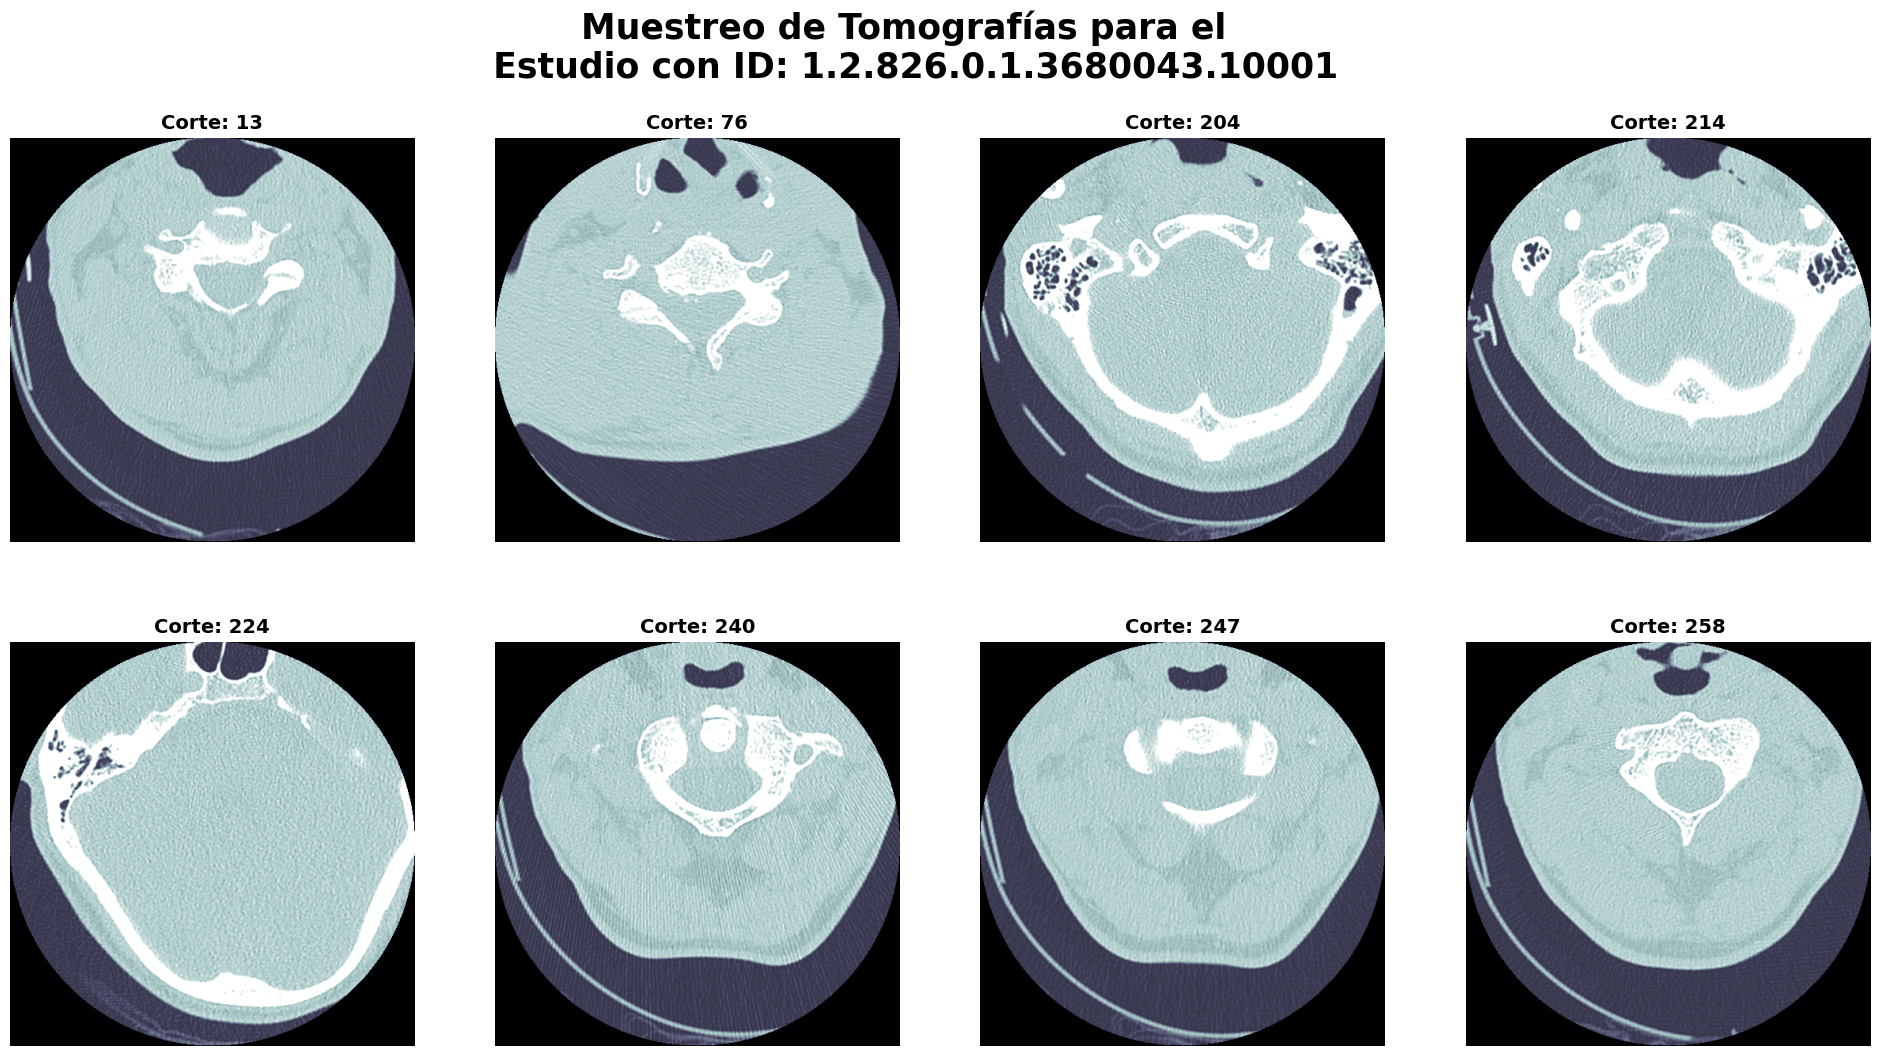

In [8]:
show_dcm_slices(studies_ids[0])

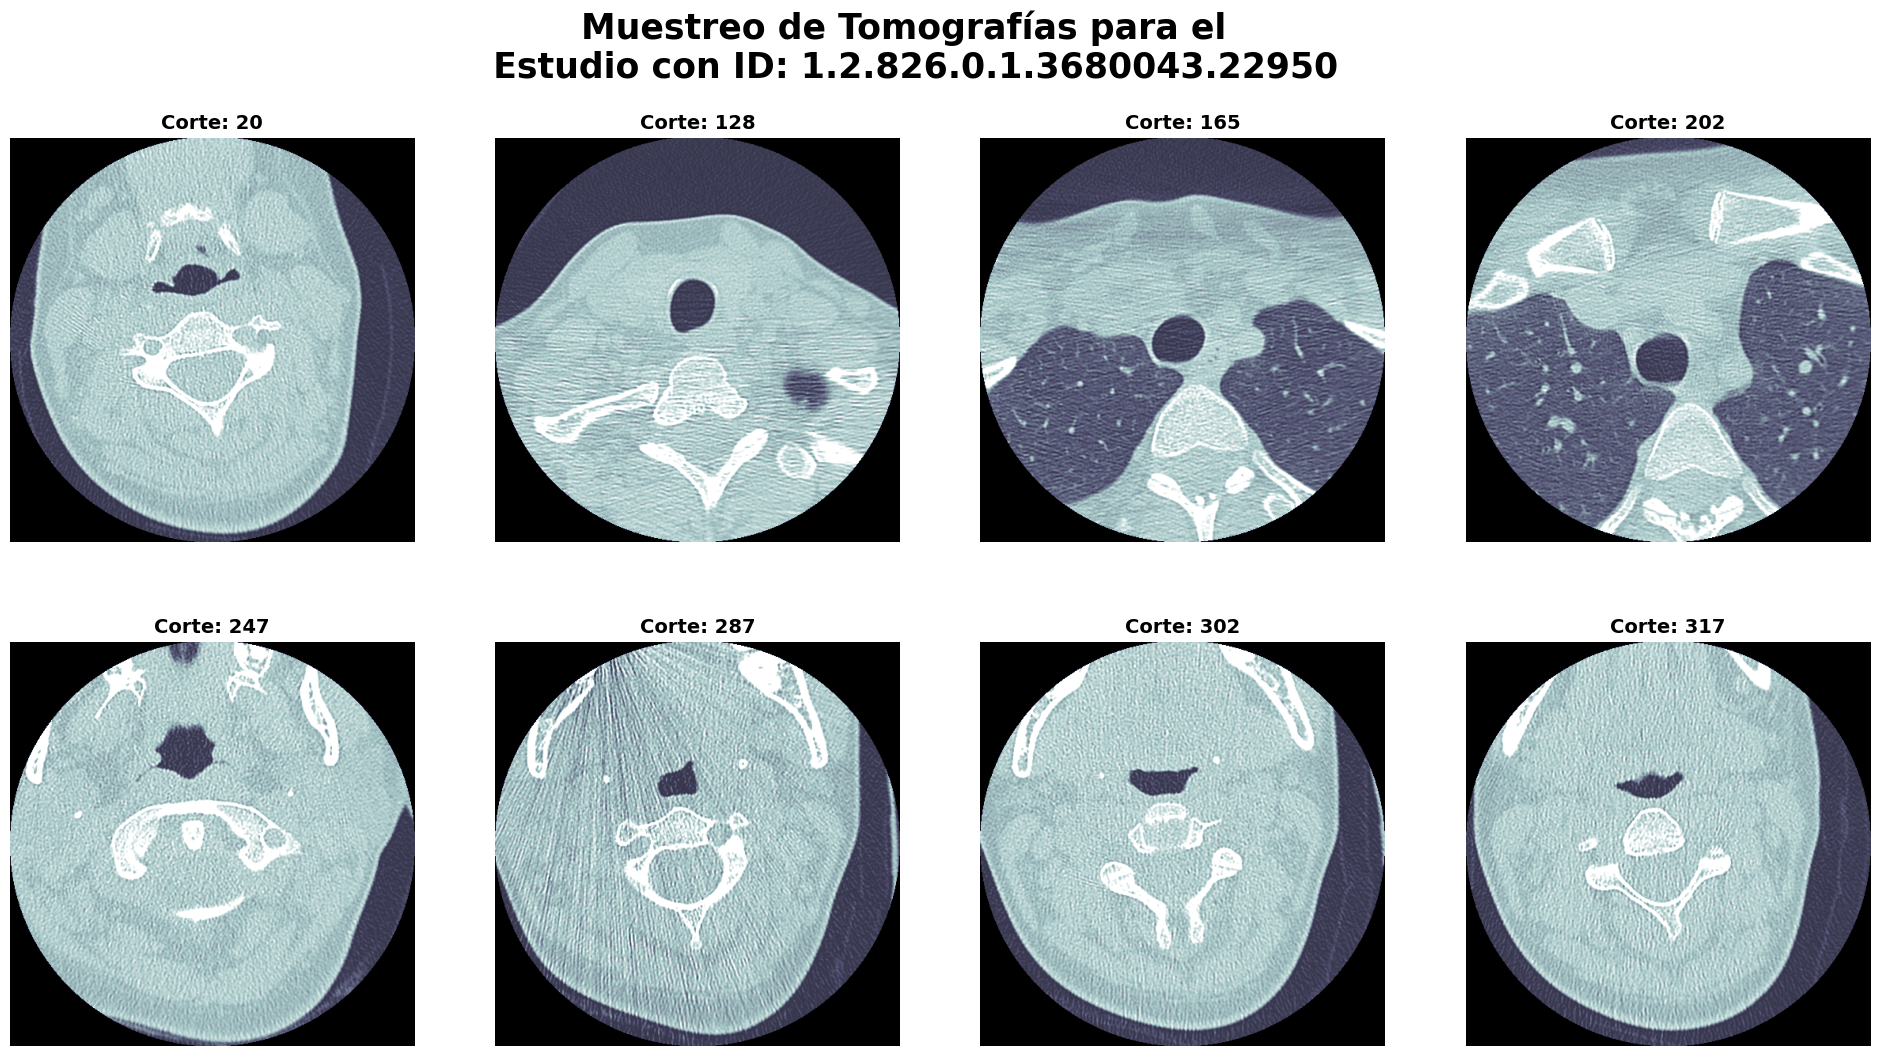

In [9]:
random_study = random.choice(studies_ids)
show_dcm_slices(random_study)

A partir de las tomografías mostradas, se observan cortes axiales centrados en la región cervical y posiblemente torácica. En el centro de las imágenes se distingue una vértebra, aunque no es posible identificar con precisión cuál es sin información adicional. Los hallazgos generales incluyen una visualización clara de la vértebra bien definidos. Sin embargo, sin marcadores anatómicos o información de referencia, no es posible determinar con exactitud el nivel vertebral de los cortes. Algunas imágenes parecen incluir partes del cráneo, lo que indica que el estudio podría abarcar la región del cuello y la base del cráneo.

### Imágenes NIFTI

Los archivos **NIfTI (.nii)** son un formato estándar para almacenar imágenes médicas, comúnmente utilizado en resonancias magnéticas (MRI) y tomografías computarizadas (CT). NIfTI, que significa "Neuroimaging Informatics Technology Initiative", es una evolución del formato **ANALYZE 7.5**. Este formato permite almacenar datos volumétricos en 3D o 4D (incluyendo el tiempo como dimensión adicional), junto con metadatos relevantes como la resolución, la orientación espacial y la escala de las imágenes. Los archivos NIfTI son ampliamente utilizados en neuroimagen y otras áreas de la medicina debido a su capacidad para manejar grandes volúmenes de datos y preservar la calidad de las imágenes.

Referencias:
- Brainder. (2012). The NIFTI file format. https://brainder.org/2012/09/23/the-nifti-file-format/

### Muestreo de Segmentaciones

In [10]:
nii_path_example = "data/segmentations/1.2.826.0.1.3680043.780.nii"
nii_example =  nib.load(nii_path_example)

# Convertir la imagen a un arreglo de Numpy
seg = nii_example.get_fdata()
seg.shape

# Alinear la orientación de la imagen
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

(195, 512, 512)

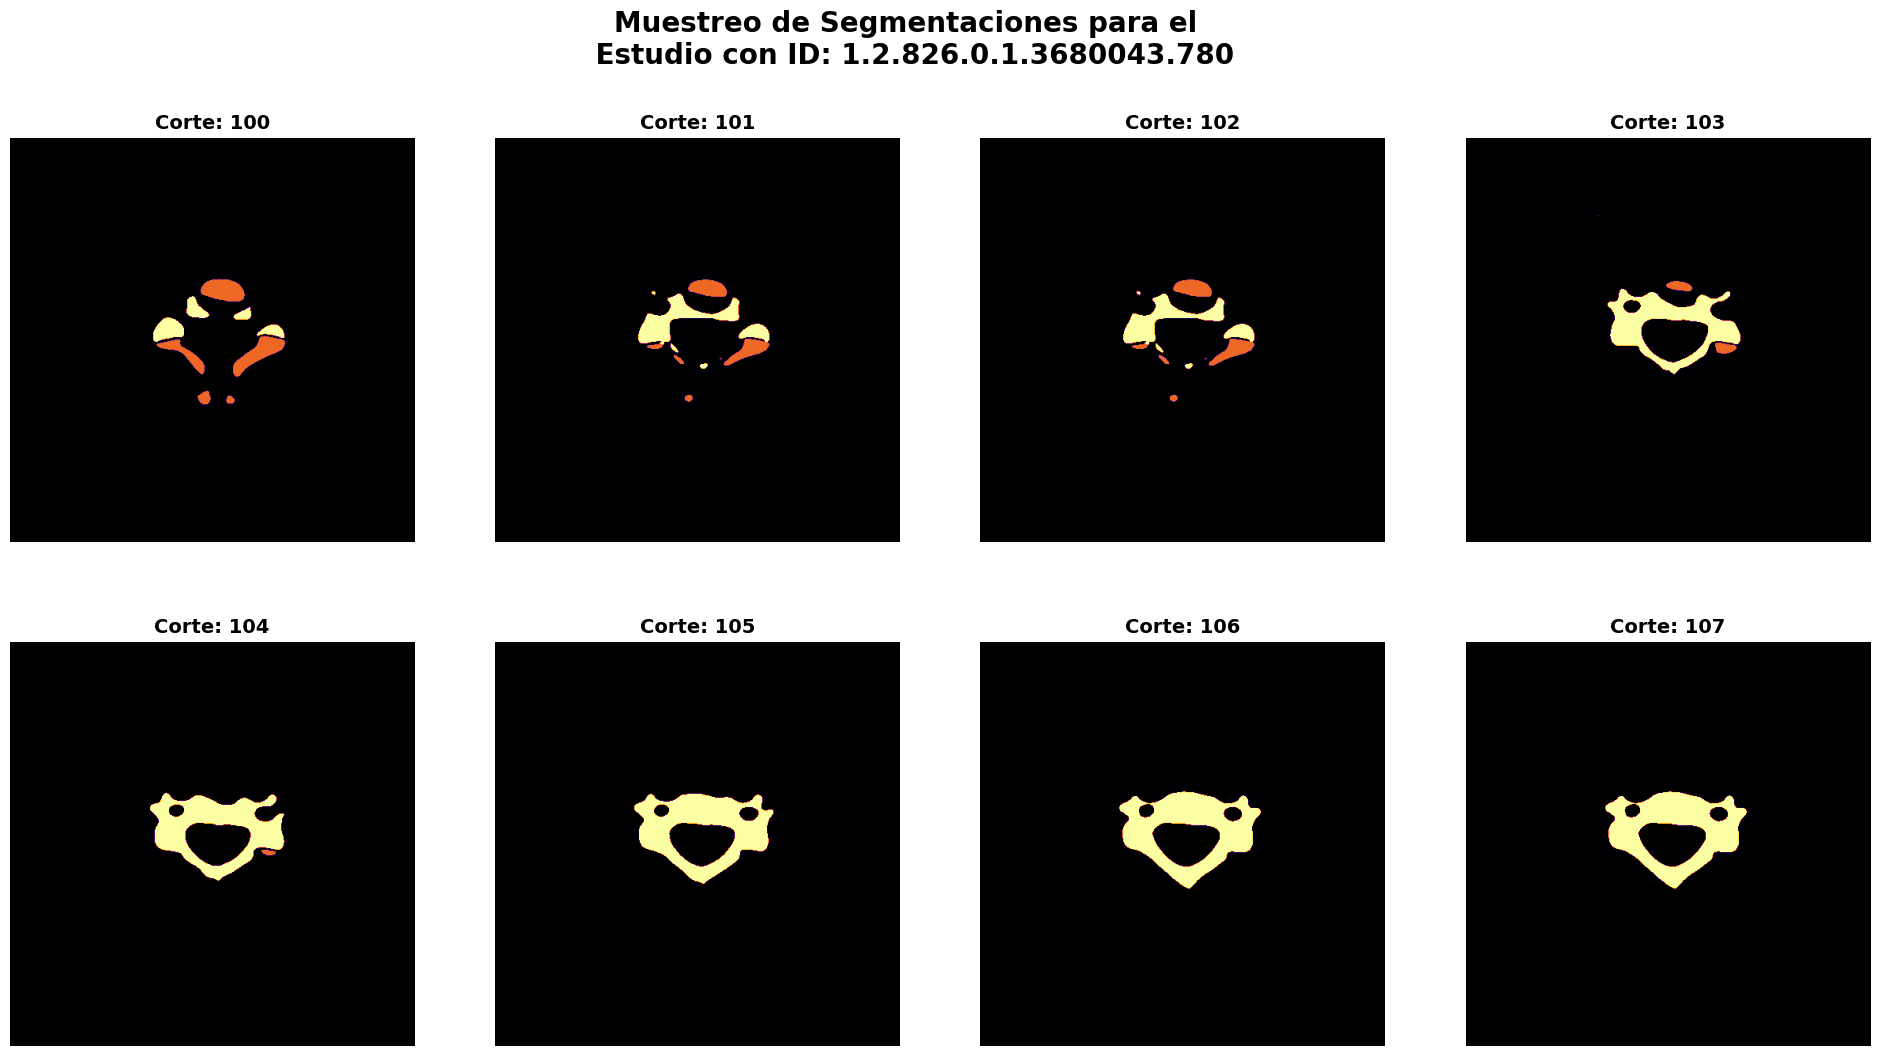

In [11]:
# Visualizar las primeras 8 imágenes segmentadas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24,12))
fig.suptitle('Muestreo de Segmentaciones para el \n Estudio con ID: 1.2.826.0.1.3680043.780', 
             weight="bold", 
             size=20)

# Iterar
for i in range(100,108):
    mask = seg[i]
    slice_no = i

    # Graficar la imagen
    x = (i-100) // 4
    y = (i-100) % 4

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Corte: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

plt.show()

A diferencia de las imágenes DICOM, estas son mas como máscaras que indican la ubicación de la vertebra en la tomografía. Esto es de mucha ayuda pues con archivos NIFTI es posible obtener la vértebra a la que pertenece la imágen.

In [12]:
# Obtener los valores únicos en la imagen segmentada
np.unique(seg[116])

array([0., 3., 4.])

In [13]:
nii_paths = glob("data/segmentations/*")
print(f"Se encontraron {len(nii_paths)} archivos NIfTI en la carpeta de segmentaciones.")

Se encontraron 87 archivos NIfTI en la carpeta de segmentaciones.


El 0 es el que indica el valor de fondo, el 3 y 4 nos indican que estamos viendo las vértebras C3 y C4.

Desafortunadamente, son muy pocos los archivos de segmentación que hay, son un total de 87 archivos .nii que equivale a tan solo el 4.3% de los 2019 pacientes examinados.

## Análisis Exploratorio de Tomografías y Metadatos Asociados

### Extracción de Metadatos Relevantes

In [14]:
def get_observation_data(path, tags):
    """
    Obtiene la información de una imagen en formato DICOM.
    Específicamente, extrae la información de las columnas:
    - Rows
    - Columns
    - SOPInstanceUID
    - ContentDate
    - SliceThickness
    - InstanceNumber
    - ImagePositionPatient
    - ImageOrientationPatient

    Args:
        path (str): Ruta de la imagen en formato DICOM.

    Returns:
        dict: Diccionario con la información de la imagen.
    """
    
    dataset = pydicom.dcmread(path, specific_tags=tags)
    
    # Dictionary to store the information from the image
    observation_data = (
        dataset.get("Rows", np.nan),
        dataset.get("Columns", np.nan),
        dataset.get("SOPInstanceUID", np.nan),
        dataset.get("ContentDate", np.nan),
        dataset.get("SliceThickness", np.nan),
        dataset.get("InstanceNumber", np.nan),
        dataset.get("ImagePositionPatient", np.nan),
        dataset.get("ImageOrientationPatient", np.nan)
    )
    
    return observation_data

### Generación de Conjunto de Metadatos

In [15]:
def get_metadata(train_df, base_path, tags, batch_size=1000):
    """
    Obtiene los metadatos deseados de los archivos DICOM y los guarda en un DataFrame.

    Args:
        train_df (pd.DataFrame): DataFrame que contiene la columna 'StudyInstanceUID' con los IDs de los estudios.
        base_path (str): Ruta base donde se encuentran las carpetas con imágenes DICOM.
        tags (list): Lista de etiquetas específicas de metadatos a extraer de los archivos DICOM.

    Returns:
        pd.DataFrame: DataFrame con los metadatos extraídos de las imágenes DICOM.
    """
    
    exceptions = 0
    all_data = []
    batch_data = []  # Lista temporal para almacenar el batch actual

    # Procesar los datos en lotes
    for k in tqdm(range(len(train_df)), desc="Processing DCMs metadata", unit="studies", unit_scale=1):
        dt = train_df.iloc[k, :]
        dcm_paths = glob(f"{base_path}/train_images/{dt.StudyInstanceUID}/*")

        for path in dcm_paths:
            try:
                # Extraer los datos de la imagen
                data = get_observation_data(path, tags)
                batch_data.append(data)
            except Exception as e:
                exceptions += 1
                print(f"Failed to process {path}. Exception: {e}")
                continue

        # Si se llega al tamaño del lote, 
        # se convierte a DataFrame y libera memoria
        if len(batch_data) >= batch_size:
            df_batch = pd.DataFrame(batch_data, columns=tags)
            all_data.append(df_batch)  # Guardar en la lista total
            batch_data = []  # Limpiamr la lista de lote para el siguiente ciclo
    
    # Convertir los datos restantes que no llegaron al tamaño de lote
    if batch_data:
        df_batch = pd.DataFrame(batch_data, columns=tags)
        all_data.append(df_batch)

    # Concatenar todo el DataFrame de forma eficiente
    meta_train_data = pd.concat(all_data, ignore_index=True)
    
    # Exportar la información a un archivo CSV
    meta_train_data.to_csv("data/meta_train.csv", index=False)

    print("Metadata created successfully")
    print(f"\tNumber of total fails: {exceptions}.")
    
    return meta_train_data

In [16]:
train_df = pd.read_csv('data/train.csv')
columns = ["Rows", "Columns", "SOPInstanceUID", "ContentDate", 
            "SliceThickness", "InstanceNumber", "ImagePositionPatient", 
            "ImageOrientationPatient"]

if not os.path.exists("data/meta_train.csv"):
    meta_train_data = get_metadata(train_df, "data", columns)
else:
    meta_train_data = pd.read_csv("data/meta_train.csv")

### Visualizacion de Metadata

In [17]:
meta_train_data["StudyInstanceUID"] = meta_train_data["SOPInstanceUID"].apply(lambda x: ".".join(x.split(".")[:-2]))
print(f"Los metadatos contienen {meta_train_data.shape[0]} filas y {meta_train_data.shape[1]} columnas.")
display(meta_train_data.head())

Los metadatos contienen 711601 filas y 9 columnas.


Rows  Columns                  SOPInstanceUID  ContentDate  SliceThickness  \
0   512      512    1.2.826.0.1.3680043.6200.1.1     20220727             1.0   
1   512      512   1.2.826.0.1.3680043.6200.1.10     20220727             1.0   
2   512      512  1.2.826.0.1.3680043.6200.1.100     20220727             1.0   
3   512      512  1.2.826.0.1.3680043.6200.1.101     20220727             1.0   
4   512      512  1.2.826.0.1.3680043.6200.1.102     20220727             1.0   

   InstanceNumber           ImagePositionPatient  \
0               1  [-118.530, -103.5302, 334.50]   
1              10  [-118.530, -103.5302, 327.30]   
2             100  [-118.530, -103.5302, 255.30]   
3             101  [-118.530, -103.5302, 254.50]   
4             102  [-118.530, -103.5302, 253.70]   

                             ImageOrientationPatient          StudyInstanceUID  
0  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200  
1  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200  
2  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200  
3  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200  
4  [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...  1.2.826.0.1.3680043.6200

Esta nuevo dataframe contiene los metadatos asociados a cada dcm mas relevantes que se seleccionaron previamente.

### Resolución de Tomografías

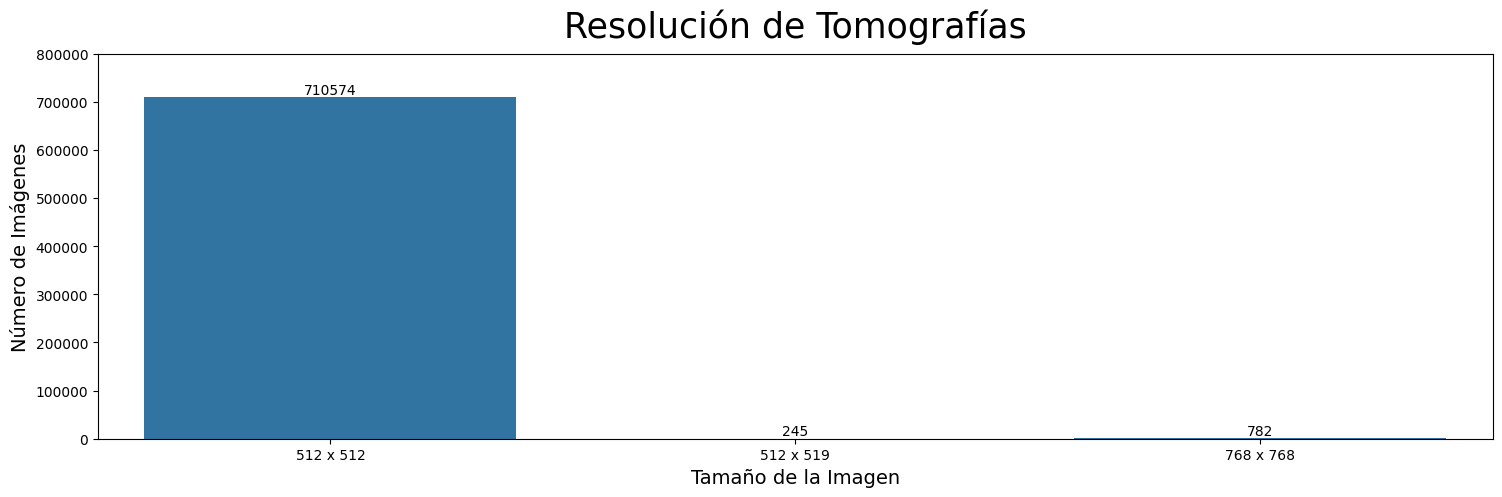

In [18]:
# Obtener el tamaño de las imágenes en píxeles 
# a partir de las columnas 'Rows' y 'Columns'
meta_train_data["ImageSize"] = meta_train_data["Rows"].astype(str) + " x " + meta_train_data["Columns"].astype(str)

# Graficar la distribución de tamaños de imágenes
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train_data, x="ImageSize")
for container in ax.containers:
    ax.bar_label(container)
plt.ylim([0,800000])
plt.xlabel("Tamaño de la Imagen", fontsize=14)
plt.ylabel("Número de Imágenes", fontsize=14)
plt.title('Resolución de Tomografías', fontsize=25, y=1.02)
plt.show()

El gráfico presentado muestra la distribución de las imágenes de tomografías de columnas cervicales en función de sus resoluciones. De acuerdo con los metadatos analizados, se encontraron tres resoluciones predominantes:

1. `512 x 512`: La gran mayoría de las imágenes, **710,574** en total, pertenecen a esta resolución, lo que sugiere que esta es la configuración más común en el conjunto de datos. Esto podría deberse a que muchas máquinas de tomografía computarizada (CT) estándar utilizan este tamaño para capturar imágenes con un equilibrio adecuado entre detalle y tamaño de archivo.

2. `512 x 519`: Solo **245** imágenes presentan esta resolución ligeramente distinta, lo que podría indicar configuraciones inusuales o ligeras variaciones en la captura de datos. Esta diferencia en altura puede deberse a ajustes específicos del equipo o a la manera en que las imágenes se procesaron o almacenaron.

3. `768 x 768`: Un total de **782** imágenes poseen esta resolución mayor, lo que sugiere que algunas máquinas de mayor definición también fueron utilizadas para capturar estas tomografías. Esta resolución podría estar asociada con estudios que requieren mayor detalle en la visualización de la anatomía cervical.

Dado el predominio de la resolución 512 x 512 en el conjunto de datos, una posible acción sería estandarizar todas las imágenes a esta resolución para asegurar la uniformidad en los análisis y evitar posibles sesgos derivados de diferentes tamaños de imagen.

Otra opción sería eliminar las imágenes que no coinciden con la resolución dominante. Esto simplificaría el preprocesamiento y permitiría un análisis más eficiente, ya que en conjunto las resoluciones de  **512 x 519** y **768 x 768** no suponen ni el 0.5% del conjunto total de datos.

### Manejo de Fechas

In [19]:
# Encontrar la cantidad de valores únicos en la columna de fecha
meta_train_data['ContentDate'].unique()

array([20220727], dtype=int64)

Esto indica que existe una unica fecha en la que fueron generadas las imágenes, por lo tanto no es data relevante y se puede eliminar del dataframe.

In [20]:
meta_train_data.drop('ContentDate', axis=1, inplace=True)

### Grosor de cortes

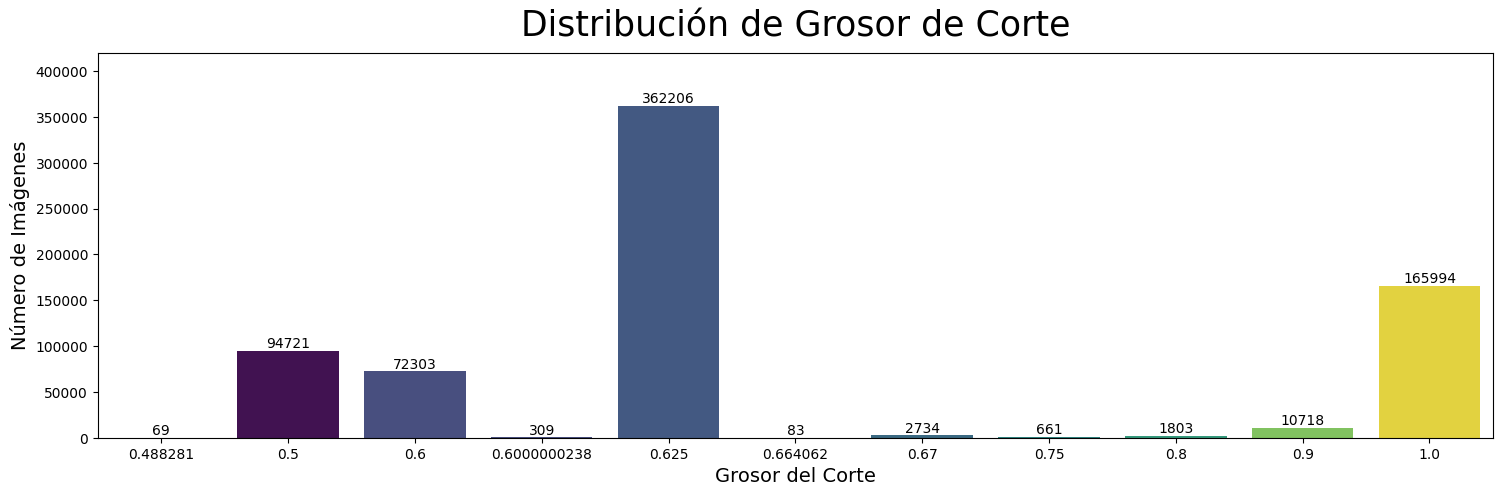

In [21]:
# Graficar la distribución de los grosores de corte
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train_data, x="SliceThickness", hue="SliceThickness", legend=False, palette="viridis")
for container in ax.containers:
    ax.bar_label(container)
plt.ylim([0,420000])
plt.xlabel("Grosor del Corte", fontsize=14)
plt.ylabel("Número de Imágenes", fontsize=14)
plt.title('Distribución de Grosor de Corte', fontsize=25, y=1.02)
plt.show()

El gráfico muestra la distribución de imágenes de tomografías según el grosor del corte, con variaciones que van desde **0.488281** hasta **1.0**. Se observa que las dos categorías más comunes son el grosor de **0.625**, con **362,206** imágenes, y **1.0**, con **165,994** imágenes, lo que sugiere que estos son los valores de corte más utilizados en el conjunto de datos. También se destacan los grosores de **0.5** y **0.6**, con **94,721** y **72,303** imágenes respectivamente. 

Grosores menos frecuentes, como **0.488281**, **0.664062**, y **0.9**, presentan un número significativamente menor de imágenes. Esta variedad en los grosores de corte podría reflejar diferentes configuraciones de captura utilizadas para estudiar distintos niveles de detalle en las estructuras anatómicas.

### Cortes por Estudio

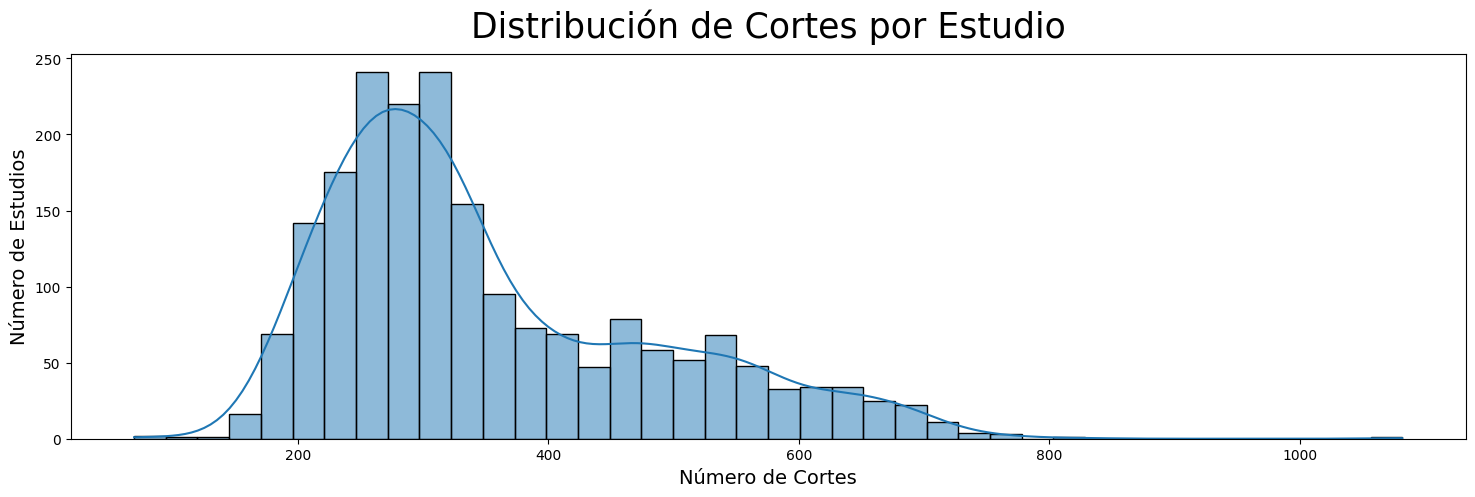

In [22]:
# Conteo de la cantidad de cortes por estudio
slice_counts = meta_train_data["StudyInstanceUID"].value_counts().reset_index()
slice_counts.columns = ["StudyInstanceUID", "count"]

# Distribution of slices counts
plt.figure(figsize=(18, 5))
sns.histplot(data=slice_counts, x="count", kde=True, bins=40, )
plt.xlabel("Número de Cortes", fontsize=14)
plt.ylabel("Número de Estudios", fontsize=14)
plt.title('Distribución de Cortes por Estudio', fontsize=25, y=1.02)
plt.show()

El gráfico muestra la distribución del número de cortes por estudio en las tomografías cervicales. La mayoría de los estudios presentan entre **200 y 400** cortes, con un pico alrededor de los **300 cortes** por estudio, donde se observa la mayor frecuencia de estudios (cercana a **250**). Este comportamiento sugiere que la mayoría de los estudios están diseñados para capturar un número considerable de cortes con el fin de obtener una imagen detallada de la columna cervical.

La distribución tiene una ligera asimetría positiva, lo que indica que aunque la mayoría de los estudios se concentran entre los **200 y 400** cortes, hay un número menor de estudios con una mayor cantidad de cortes, llegando incluso hasta más de **1000 cortes** en algunos casos. Este rango más amplio de estudios podría estar relacionado con variaciones en la longitud de la columna explorada o con protocolos clínicos que requieren mayor resolución o un mayor número de imágenes.

La mayor parte de los estudios tienen un número moderado de cortes, alrededor de los **300**, pero existe una variedad significativa en el número de cortes por estudio, con algunos que superan los **600** cortes, lo cual puede estar relacionado con necesidades clínicas específicas.

### Posicionamiento del Paciente durante su Tomografía

In [23]:
# Convertir columnas de coordenadas a string
meta_train_data["ImagePositionPatient"] = meta_train_data["ImagePositionPatient"].astype(str)
meta_train_data["ImageOrientationPatient"] = meta_train_data["ImageOrientationPatient"].astype(str)

# Extraer las coordenadas x, y, z de la columna 'ImagePositionPatient'
meta_train_data['ImagePositionPatient_x'] = meta_train_data['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[0]))
meta_train_data['ImagePositionPatient_y'] = meta_train_data['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[1]))
meta_train_data['ImagePositionPatient_z'] = meta_train_data['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[2]))

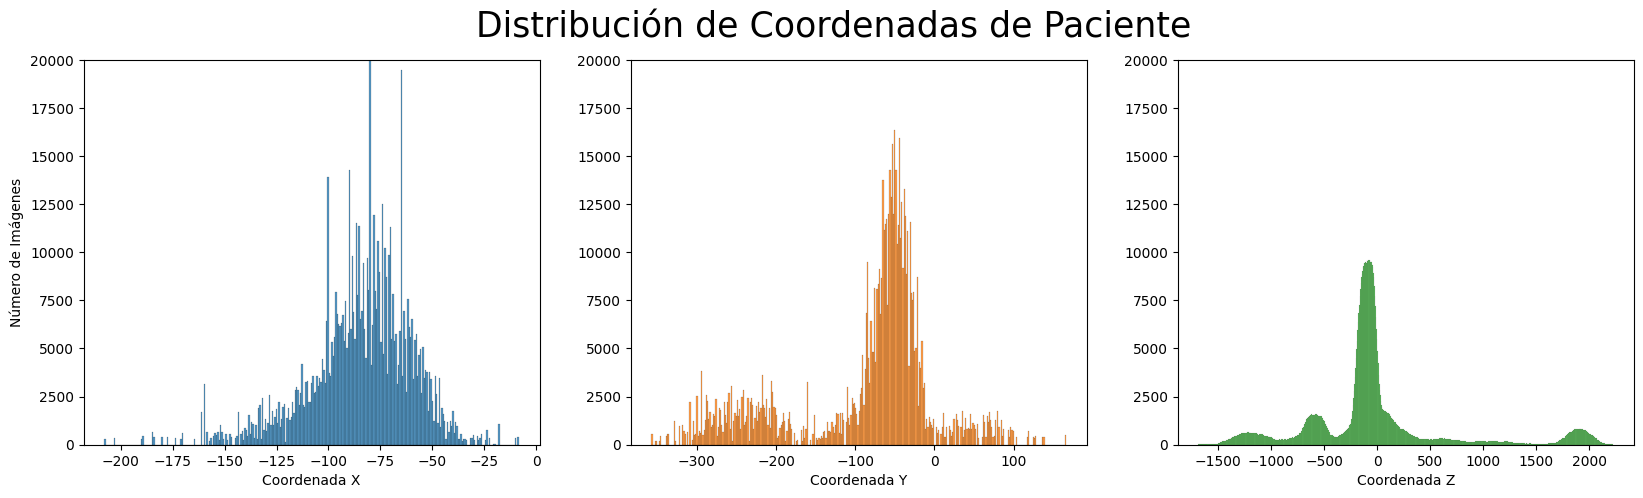

In [24]:
# Graficar la distribución de las coordenadas x, y, z
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(meta_train_data['ImagePositionPatient_x'])
plt.ylim([0,20000])
plt.ylabel('Número de Imágenes')
plt.xlabel('Coordenada X')

plt.subplot(1,3,2)
sns.histplot(meta_train_data['ImagePositionPatient_y'], color='C1')
plt.ylabel('')
plt.ylim([0,20000])
plt.ylabel('')
plt.xlabel('Coordenada Y')

plt.subplot(1,3,3)
sns.histplot(meta_train_data['ImagePositionPatient_z'], color='C2')
plt.ylabel('')
plt.ylim([0,20000])
plt.ylabel('')
plt.xlabel('Coordenada Z')

plt.suptitle('Distribución de Coordenadas de Paciente', fontsize=25)
plt.show()

El gráfico muestra la distribución de las coordenadas del paciente (X, Y, Z) basadas en la variable `ImagePositionPatient` extraída de los metadatos DICOM de las imágenes. Las tres coordenadas ofrecen información sobre la posición física de las imágenes en relación con el cuerpo del paciente.

1. **Coordenada X**: La mayoría de las imágenes están centradas entre **-150** y **0**, con un pico muy pronunciado en el rango entre **-100** y **-50**. Esto sugiere que la mayoría de las tomografías capturan áreas similares de la anatomía en el plano horizontal, probablemente correspondiendo a una vista transversal del cuerpo.

2. **Coordenada Y**: La distribución de la coordenada Y es más dispersa, pero también se concentra principalmente en el rango de **-150** a **0**, con un pico más definido alrededor de **-100**. Este comportamiento indica que la posición en el eje vertical varía, pero sigue concentrándose en una región similar de la anatomía, correspondiente probablemente a la columna cervical.

3. **Coordenada Z**: La distribución de la coordenada Z, que corresponde a la profundidad, muestra una mayor variabilidad. Sin embargo, hay un pico prominente en el valor cercano a **0**, lo que indica que la mayoría de las imágenes están centradas en una posición particular en el eje Z, con algunas capturas extendiéndose hacia posiciones más alejadas en ambos extremos del eje.

En conjunto, estas distribuciones sugieren que la mayoría de las imágenes están centradas en una región consistente del cuerpo del paciente, lo que tiene sentido dada la naturaleza del conjunto de datos (tomografías de la columna cervical). Las variaciones en las coordenadas reflejan diferentes planos y profundidades de corte, pero en general parecen capturar áreas similares. Este tipo de información es útil para garantizar que todas las imágenes cubren regiones comparables, lo que puede ser importante para un modelo de detección de fracturas al evitar sesgos de posicionamiento.

### Visualización 3D

In [25]:
class DrawMaskSample():
    
    def __init__(self, nii_paths, i, ax):
        self.i = i
        self.ax = ax
        self.nii_sample = nib.load(nii_paths[self.i]).get_fdata()
        self.get_xyz()
        self.draw_sample_3d()
        
    def get_xyz(self):
        self.xyz_li = []
        cnt = 0
        max_cnt = self.nii_sample.shape[-1]
        for iter_z, (iter_img) in enumerate(self.nii_sample.transpose(2,0,1)):
            for iter_x, iter_arr_y in enumerate(iter_img):
                iter_arr_y = np.where(iter_arr_y)[0]
                if len(iter_arr_y) >= 1:
                    iter_arr_y = list(set([iter_arr_y.max(), iter_arr_y.min()]))
                    xyz = [(iter_x, iter_y, iter_z) for iter_y in iter_arr_y if np.any(iter_y)]
                    self.xyz_li.append(xyz)
            cnt += 1

    def draw_sample_3d(self):
        xyz_matrix = np.array(list(itertools.chain.from_iterable(self.xyz_li)))
        X = xyz_matrix[:,0]
        Y = xyz_matrix[:,1]
        Z = xyz_matrix[:,2]

        self.ax.scatter(X, Y, Z, s=1, alpha=0.05, color='#e3dac9')
        xlim, ylim, zlim = self.nii_sample.shape
        self.ax.set_xlim(0, xlim)
        self.ax.set_ylim(0, ylim)
        self.ax.set_zlim(0, zlim)
        self.ax.set_title(f'Muestra - ({self.i+1})')
        self.ax.set_yticklabels([])
        self.ax.set_xticklabels([])
        self.ax.set_zticklabels([])
        self.ax.set_facecolor('#081921')

C:\Users\diego\AppData\Local\Temp\ipykernel_6848\3809030530.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


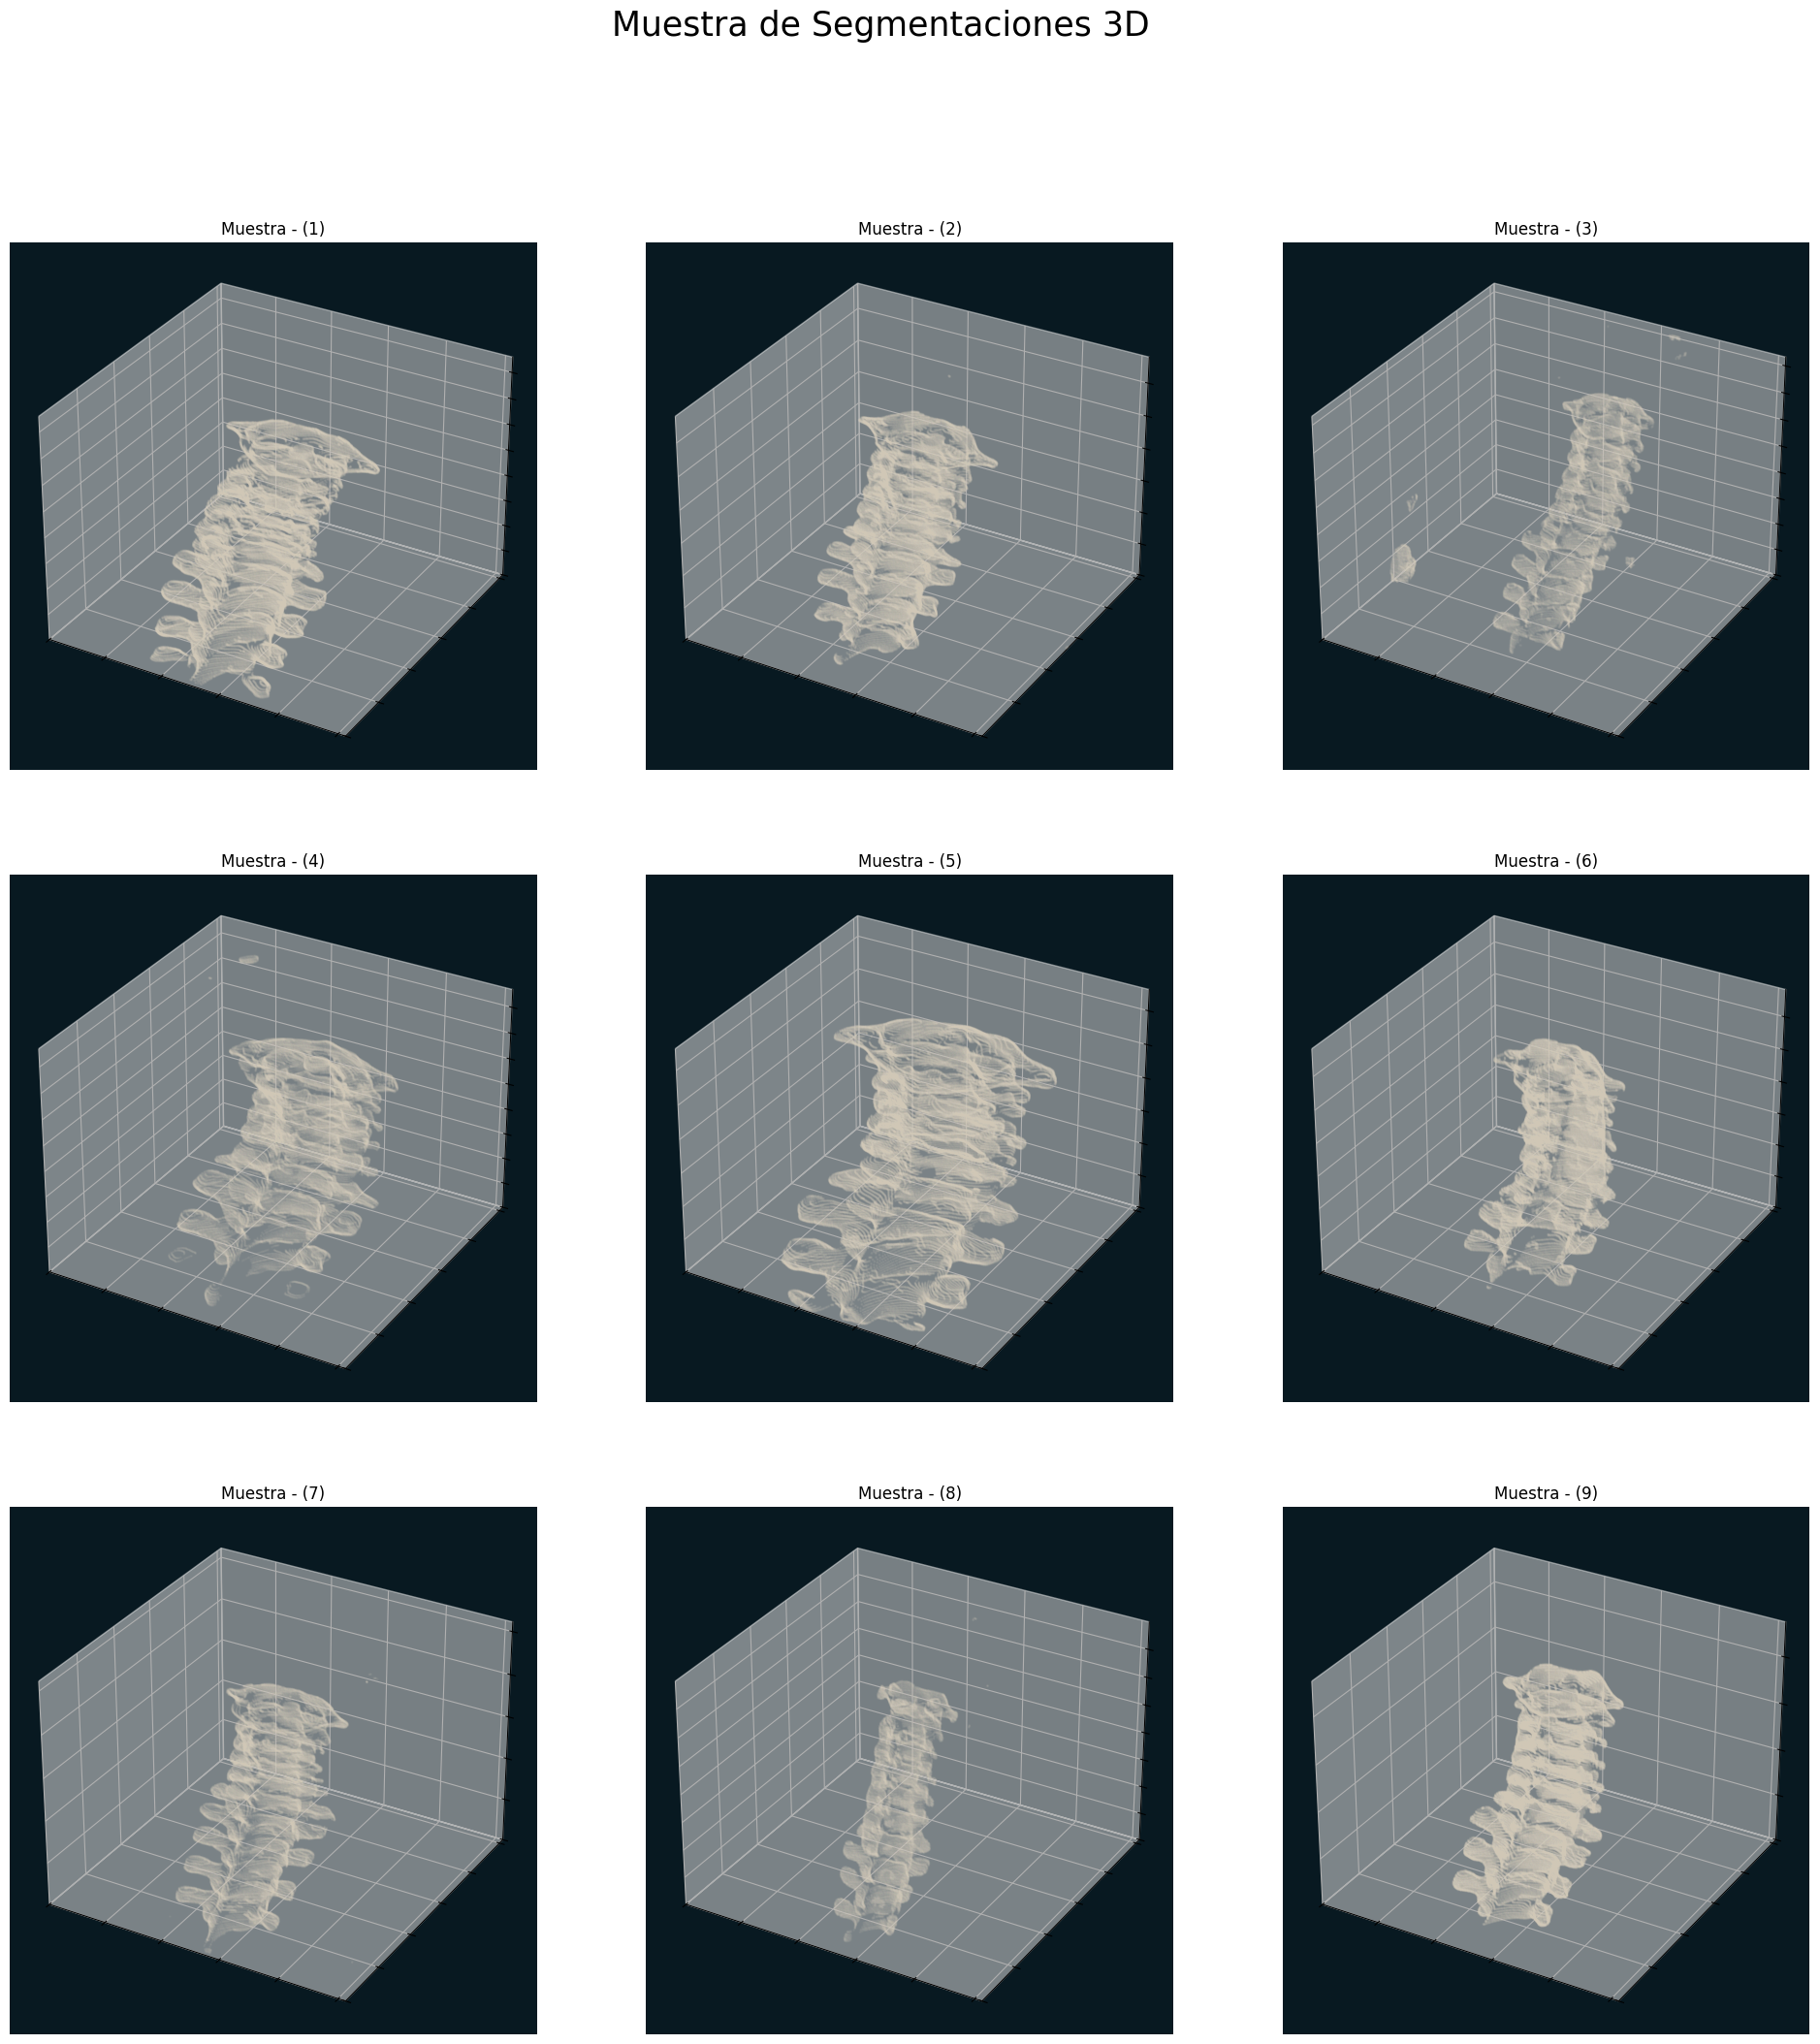

In [26]:
fig = plt.figure(figsize=(24,24))
for i in range(9):
    ax = fig.add_subplot(int(f'33{i+1}'), projection='3d')
    DrawMaskSample(nii_paths, i, ax)

plt.tight_layout()
plt.suptitle('Muestra de Segmentaciones 3D', fontsize=25)
plt.show()

La representación 3D mostrada en la imagen corresponde a una serie de segmentaciones de la columna cervical obtenidas a partir de archivos NIfTI. Cada imagen en la cuadrícula muestra una reconstrucción tridimensional de las vértebras cervicales, generada a partir de los cortes en 2D presentes en las imágenes médicas. La segmentación 3D permite visualizar con mayor claridad la estructura ósea en su conjunto, facilitando el análisis de posibles fracturas, deformidades o lesiones.

Las muestras expuestas representan distintas orientaciones o vistas del mismo segmento anatómico, lo que puede ser particularmente útil para el diagnóstico en áreas complejas como la columna vertebral. Al renderizar estas imágenes a partir de datos volumétricos en NIfTI, es posible explorar detalles de las vértebras desde múltiples ángulos, lo que provee una visión más integral y precisa.